# Распознавание рукописных символов с помощью KNN

## 1. Импорт библиотек

In [1]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## 2. Конфигурация

In [2]:
DATA_PATH = './dataset'

TARGET_SIZE = 45
TRAIN_RATIO = 0.8
GAP_SIZE = 10

SYMBOLS = ['0','1','2','3','4','5','6','7','8','9','+','-','*','t','x','y','w','h','(',')',',']

SAMPLES_PER_SYMBOL = 40

## 3. Генерация данных

In [3]:
def center_in_45(image, target_size=45):
    if image is None:
        return np.zeros((target_size, target_size), dtype=np.uint8)
    
    h, w = image.shape
    
    squared = np.zeros((target_size, target_size), dtype=np.uint8)
    
    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2
    
    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

def load_training_data(data_path, symbols, train_size=0.8):
    X_train, y_train = [], []
    
    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)
        
        if not os.path.exists(symbol_path):
            print(f"Пропущен символ {symbol}: папка не найдена")
            continue
            
        images = [f for f in os.listdir(symbol_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images.sort()
        
        if not images:
            print(f"Пропущен символ {symbol}: нет изображений")
            continue
            
        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        
        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_45(img)
                X_train.append(img_resized.flatten())
                y_train.append(symbol)
    
    return np.array(X_train), np.array(y_train)

## 4. Генератор последовательностей

In [4]:
class SequenceGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.symbols_data = {}
        self.available_symbols = []
        self.load_symbols()
    
    def load_symbols(self):
        folders = [f for f in os.listdir(self.data_path) 
                  if os.path.isdir(os.path.join(self.data_path, f))]
        
        for folder in folders:
            folder_path = os.path.join(self.data_path, folder)
            images = []
            
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(folder_path, filename)
                    images.append(file_path)
            
            if images:
                self.symbols_data[folder] = images
                self.available_symbols.append(folder)
    
    def generate_sequence_image(self, length=8):
        if not self.available_symbols:
            return None
            
        sequence_images = []
        labels = []
        
        for i in range(length):
            symbol = random.choice(self.available_symbols)
            image_path = random.choice(self.symbols_data[symbol])
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is not None:
                sequence_images.append(image)
                labels.append(symbol)
        
        spacing = 20
        total_width = sum(img.shape[1] for img in sequence_images) + spacing * (len(sequence_images) - 1)
        max_height = max(img.shape[0] for img in sequence_images)
        
        sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

        x_offset = 0
        for img in sequence_images:
            h, w = img.shape[:2]
            y_offset = (max_height - h) // 2
            sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
            x_offset += w + spacing
        
        return {
            'image': sequence_img,
            'labels': labels,
            'text': ''.join(labels),
            'individual_images': sequence_images
        }

## 5. Сегментатор последовательностей

In [5]:
class SequenceSegmenter:
    def extract_characters(self, sequence_image, original_labels):
        non_space_labels = [label for label in original_labels if label != ' ']
        
        img_gray = sequence_image.copy()
        kernel = np.ones((3,3), np.uint8)
        img_gray = cv2.erode(img_gray, kernel, iterations=1)
        img_gray = cv2.bitwise_not(img_gray)
        
        ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
        thresh = np.uint8(thresh)
        contours, h = cv2.findContours(thresh, cv2.RETR_EXTERNAL, 2)
        
        contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
        crops = []

        img_with_boxes = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
        
        for i in range(len(contours_sorted)):
            cnt = contours_sorted[i] 
            x, y, w, h = cv2.boundingRect(cnt)
            while (w > 45):
                w -= 1
            if w * h > 50:
                cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 0, 255), 1)
                crops.append([x, y, w, h])

        plt.figure(figsize=(10, 3))
        plt.imshow(img_with_boxes)
        plt.title('Найденные контуры символов')
        plt.axis('off')
        plt.show()

        character_data = []
        for i in range(len(crops)):
            x, y, w, h = crops[i]
            
            img_crop = sequence_image[y:y+h, x:x+w]
            
            img_processed = cv2.bitwise_not(img_crop)
            img_resized = center_in_45(img_processed)
            
            true_label = non_space_labels[i] if i < len(non_space_labels) else "?"
            
            character_data.append((true_label, img_resized))

        return character_data

## 6. Основная программа

In [6]:
def main():
    print("=" * 60)
    print("ЗАГРУЗКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛИ")
    print("=" * 60)

    symbols = []
    if os.path.exists(DATA_PATH):
        symbols = [f for f in os.listdir(DATA_PATH) 
                   if os.path.isdir(os.path.join(DATA_PATH, f))]

    print("Доступные символы:", symbols)


    X_train, y_train = load_training_data(DATA_PATH, symbols, train_size=0.8)
    print(f"Загружено {len(X_train)} изображений для обучения")

    print("\nОБУЧЕНИЕ МОДЕЛЕЙ KNN:")
    models = {}

    knn1 = KNeighborsClassifier(n_neighbors=1)
    knn1.fit(X_train, y_train)
    models['knn1'] = knn1
    print("KNN-1 обучен")

    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn3.fit(X_train, y_train)
    models['knn3'] = knn3
    print("KNN-3 обучен")

    knn5 = KNeighborsClassifier(n_neighbors=5)
    knn5.fit(X_train, y_train)
    models['knn5'] = knn5
    print("KNN-5 обучен")

    knn7 = KNeighborsClassifier(n_neighbors=7)
    knn7.fit(X_train, y_train)
    models['knn7'] = knn7
    print("KNN-7 обучен")

    print("Все модели успешно обучены!")
    print("\n" + "=" * 60)
    print("ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ")
    print("=" * 60)

    generator = SequenceGenerator(DATA_PATH)
    sequence_data = generator.generate_sequence_image(length=6)

    if sequence_data:
        plt.figure(figsize=(12, 3))
        plt.imshow(sequence_data['image'], cmap='gray')
        plt.title(f'Тестовая последовательность: {sequence_data["text"]}')
        plt.axis('off')
        plt.show()

        segmenter = SequenceSegmenter()
        characters = segmenter.extract_characters(sequence_data['image'], sequence_data['labels'])
        
        if characters:
            print("\n" + "=" * 60)
            print("СРАВНЕНИЕ ТОЧНОСТИ МОДЕЛЕЙ")
            print("=" * 60)
            
            results = {}
            
            for model_name, model in models.items():
                print(f"\n--- Модель {model_name} ---")
                
                predicted_labels = []
                
                for i, (true_label, char_img) in enumerate(characters):
                    predicted = model.predict([char_img.flatten()])[0]
                    predicted_labels.append(predicted)
                    
                    status = "+" if predicted == true_label else "-"
                    print(f"    {status} Символ {i+1}: истина '{true_label}', предсказано '{predicted}'")
                
                predicted_text = ''.join(predicted_labels)
                original_text = sequence_data['text']
                
                correct = sum(1 for true, pred in zip(sequence_data['labels'], predicted_labels) if true == pred)
                total = len(sequence_data['labels'])
                accuracy = correct / total
                
                print(f"    Оригинал:  {original_text}")
                print(f"    Предсказано: {predicted_text}")
                print(f"    Точность: {accuracy:.1%} ({correct}/{total})")
                
                results[model_name] = {
                    'accuracy': accuracy,
                    'predicted': predicted_text,
                    'correct': correct,
                    'total': total
                }
            
            print("\n" + "=" * 60)
            print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
            print("=" * 60)

            sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

            for model_name, result in sorted_results:
                print(f"{model_name}: {result['accuracy']:.1%} - '{result['predicted']}'")

            best_accuracy = sorted_results[0][1]['accuracy']
            best_models = [model for model, res in results.items() if res['accuracy'] == best_accuracy]

            if len(best_models) == 1:
                print(f"ЛУЧШАЯ МОДЕЛЬ: {best_models[0]} с точностью {best_accuracy:.1%}")
            else:
                print(f"НЕСКОЛЬКО ЛУЧШИХ МОДЕЛЕЙ с точностью {best_accuracy:.1%}: {', '.join(best_models)}")
    else:
        print("Не удалось сгенерировать тестовую последовательность")


## 7. Запуск программы

ЗАГРУЗКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛИ
Доступные символы: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'h', 't', 'times', 'w', 'y']
Загружено 336 изображений для обучения

ОБУЧЕНИЕ МОДЕЛЕЙ KNN:
KNN-1 обучен
KNN-3 обучен
KNN-5 обучен
KNN-7 обучен
Все модели успешно обучены!

ТЕСТИРОВАНИЕ НА СГЕНЕРИРОВАННОЙ ПОСЛЕДОВАТЕЛЬНОСТИ


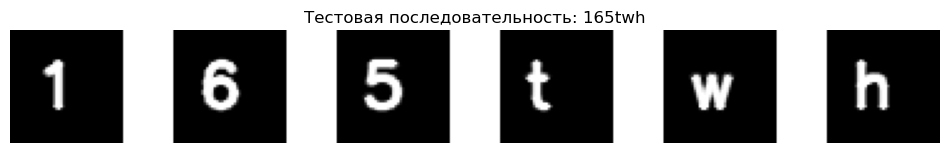

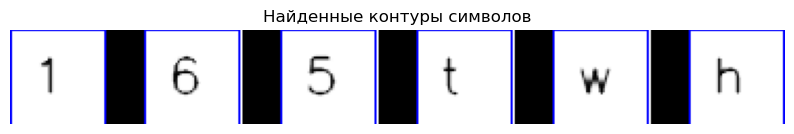


СРАВНЕНИЕ ТОЧНОСТИ МОДЕЛЕЙ

--- Модель knn1 ---
    + Символ 1: истина '1', предсказано '1'
    + Символ 2: истина '6', предсказано '6'
    + Символ 3: истина '5', предсказано '5'
    + Символ 4: истина 't', предсказано 't'
    + Символ 5: истина 'w', предсказано 'w'
    + Символ 6: истина 'h', предсказано 'h'
    Оригинал:  165twh
    Предсказано: 165twh
    Точность: 100.0% (6/6)

--- Модель knn3 ---
    + Символ 1: истина '1', предсказано '1'
    + Символ 2: истина '6', предсказано '6'
    + Символ 3: истина '5', предсказано '5'
    + Символ 4: истина 't', предсказано 't'
    + Символ 5: истина 'w', предсказано 'w'
    + Символ 6: истина 'h', предсказано 'h'
    Оригинал:  165twh
    Предсказано: 165twh
    Точность: 100.0% (6/6)

--- Модель knn5 ---
    + Символ 1: истина '1', предсказано '1'
    + Символ 2: истина '6', предсказано '6'
    + Символ 3: истина '5', предсказано '5'
    + Символ 4: истина 't', предсказано 't'
    + Символ 5: истина 'w', предсказано 'w'
    + Символ 6:

In [10]:
main()

## 8. Генератор тестовых данных

In [7]:
def generate_test_data():
    if os.path.exists(DATA_PATH) and len(os.listdir(DATA_PATH)) > 0:
        print(f"Папка {DATA_PATH} уже содержит данные")
        return
    
    print("Генерация тестовых данных...")
    
    for symbol in SYMBOLS:
        folder_name = 'times' if symbol == '*' else ('X' if symbol == 'x' else symbol)
        folder_path = os.path.join(DATA_PATH, folder_name)
        os.makedirs(folder_path, exist_ok=True)
        
        for i in range(20):
            img = np.zeros((45, 45), dtype=np.uint8)
            
            cv2.putText(img, symbol, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                       0.8, 255, 2, cv2.LINE_AA)
            
            cv2.imwrite(os.path.join(folder_path, f'{symbol}_{i:03d}.png'), img)
        
        print(f"  Создано 20 изображений для символа '{symbol}'")
    
    print(f"\n Тестовые данные созданы в папке {DATA_PATH}")

generate_test_data()

Генерация тестовых данных...
  Создано 20 изображений для символа '0'
  Создано 20 изображений для символа '1'
  Создано 20 изображений для символа '2'
  Создано 20 изображений для символа '3'
  Создано 20 изображений для символа '4'
  Создано 20 изображений для символа '5'
  Создано 20 изображений для символа '6'
  Создано 20 изображений для символа '7'
  Создано 20 изображений для символа '8'
  Создано 20 изображений для символа '9'
  Создано 20 изображений для символа '+'
  Создано 20 изображений для символа '-'
  Создано 20 изображений для символа '*'
  Создано 20 изображений для символа 't'
  Создано 20 изображений для символа 'x'
  Создано 20 изображений для символа 'y'
  Создано 20 изображений для символа 'w'
  Создано 20 изображений для символа 'h'
  Создано 20 изображений для символа '('
  Создано 20 изображений для символа ')'
  Создано 20 изображений для символа ','

 Тестовые данные созданы в папке ./dataset
